### Imports

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter 
from lifelines.statistics import logrank_test

### Constants

In [2]:
base_dir = Path('../../').resolve()
os_data  = base_dir /"data"/"clinical"/"clinical.tsv"
gene_mtx = base_dir /'results'/'final'/'analysis'/'final.csv'

### Load Data

In [3]:
os_df   = pd.read_csv(os_data,sep='\t',usecols=['cases.submitter_id','demographic.vital_status','diagnoses.days_to_last_follow_up','demographic.days_to_death'])
gene_df = pd.read_csv(gene_mtx)

### Main

In [4]:
os_df.columns = [i.split('.')[1] for i in os_df.columns]
os_df = os_df.rename(columns = {"submitter_id":"case_id"})
os_df.drop_duplicates(inplace=True)
os_df.head()

,case_id,days_to_death,vital_status,days_to_last_follow_up
0,C3N-02682,109,Dead,109.0
1,C224106,614,Dead,'--
2,C3L-01146,509,Dead,508.0
5,C3L-04213,'--,Alive,1450.0
7,C3L-04084,274,Dead,206.0


In [5]:
os_df['vital_status'].value_counts()

vital_status
Dead     146
Alive     50
Name: count, dtype: int64

In [6]:
os_df[(os_df['days_to_death']=="'--") & (os_df['vital_status']=="Dead") ] ## should be 0

,case_id,days_to_death,vital_status,days_to_last_follow_up


In [7]:
os_df[(os_df['days_to_last_follow_up']=="'--") & (os_df['vital_status']=="Alive") ] ## should be 0

,case_id,days_to_death,vital_status,days_to_last_follow_up


In [8]:
def mk_OS(df:pd.DataFrame):
    df['OS_event'] = (df['vital_status']=='Dead').astype(int)
    df['OS_time'] = (
        pd.to_numeric(
            df['days_to_last_follow_up'].where(
                df['vital_status'] == 'Alive',
                df['days_to_death']
            ),
            errors='coerce'
        ).astype('Int64')
    )
    df.drop(columns=['vital_status','days_to_death','days_to_last_follow_up'],inplace=True)
    return df

In [9]:
df = mk_OS(os_df)

### Merging

In [10]:
def merge_func(gene_df:pd.DataFrame,os_df:pd.DataFrame):
    df = pd.merge(gene_df,os_df,on='case_id',how='left').reset_index(drop=True)
    return df


In [11]:
main_df = merge_func(gene_df,os_df)
main_df.head()

,case_id,amp_EGFR,amp_SEC61G,amp_LANCL2,amp_VSTM2A,amp_VOPP1,amp_AC092647.5,amp_MRPS17,amp_NIPSNAP2,amp_PSPH,...,amp_CCT6A,amp_CDK4,amp_CYP27B1,amp_EEF1AKMT3,amp_MARCHF9,amp_METTL1,amp_OS9,amp_SUMF2,OS_event,OS_time
0,C3L-00104,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,1,1,129
1,C3L-00365,0,0,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,1,1,322
2,C3L-00674,0,0,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,1,1,478
3,C3L-00677,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,1,1,155
4,C3L-01040,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,1,0,608


### Survival Analysis

In [12]:
def km_logrank(df:pd.DataFrame, gene_var:str,pvals,time_col="OS_time", event_col="OS_event"):
    group_pos = df[gene_var] == 1
    group_neg = df[gene_var] == 0
    print(f"N with event ({gene_var}=1):", group_pos.sum())
    print(f"N with event ({gene_var}=0):", group_neg.sum())
    
    
    kmf_pos = KaplanMeierFitter()
    kmf_neg = KaplanMeierFitter()
    
    kmf_pos.fit(df.loc[group_pos, time_col],
                df.loc[group_pos, event_col],
                label=f"{gene_var}=1")
    kmf_neg.fit(df.loc[group_neg, time_col],
                df.loc[group_neg, event_col],
                label=f"{gene_var}=0")
    
    ax = kmf_pos.plot(ci_show=True,color='#f53b57')
    kmf_neg.plot(ax=ax, ci_show=True,color='#00d8d6')
    plt.xlabel("Time (days)")
    plt.ylabel("Survival probability")
    plt.title(f"KM by {gene_var}")
    plt.grid(True)
    plt.show()
    
    res = logrank_test(
        df.loc[group_pos, time_col],
        df.loc[group_neg, time_col],
        event_observed_A=df.loc[group_pos, event_col],
        event_observed_B=df.loc[group_neg, event_col]
    )
    pval = (res.summary.loc[0,'p'])
    print("Median survival (1):", kmf_pos.median_survival_time_)
    print("Median survival (0):", kmf_neg.median_survival_time_)
    print('\n')
    print(res.summary)
    print('\n')
    return pval

========================== Working on CNVs ===========================
------------------------ Working on amp_EGFR -------------------------
N with event (amp_EGFR=1): 114
N with event (amp_EGFR=0): 56


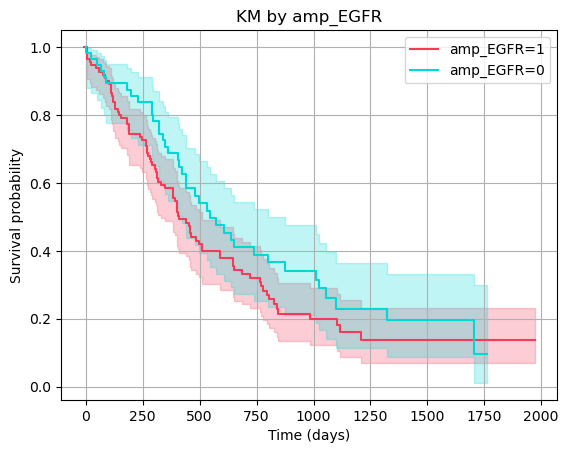

Median survival (1): 411.0
Median survival (0): 546.0


   test_statistic         p  -log2(p)
0        2.022612  0.154972  2.689917


----------------------- Working on amp_SEC61G ------------------------
N with event (amp_SEC61G=1): 113
N with event (amp_SEC61G=0): 57


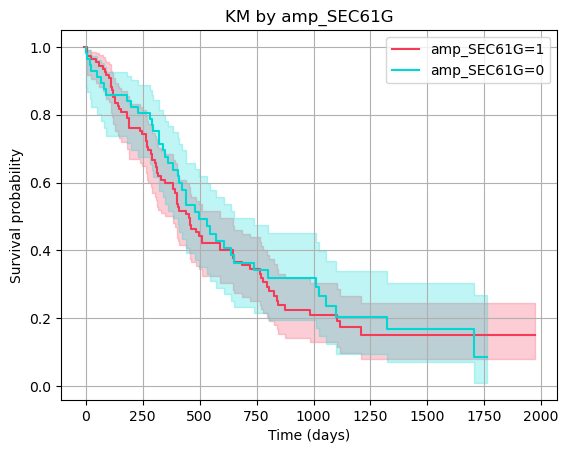

Median survival (1): 453.0
Median survival (0): 496.0


   test_statistic         p  -log2(p)
0        0.315426  0.574369  0.799949


----------------------- Working on amp_LANCL2 ------------------------
N with event (amp_LANCL2=1): 127
N with event (amp_LANCL2=0): 43


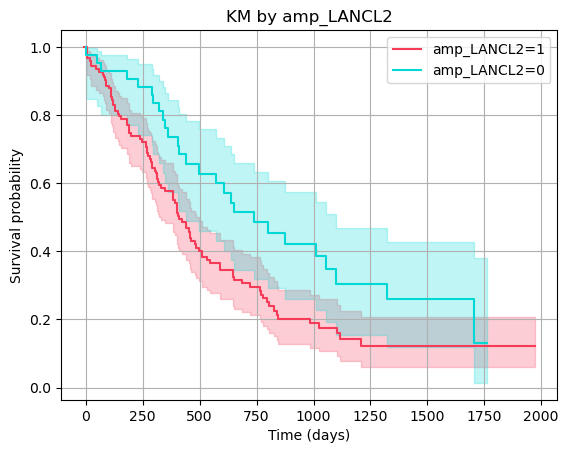

Median survival (1): 411.0
Median survival (0): 738.0


   test_statistic         p  -log2(p)
0         6.46728  0.010988  6.507946


----------------------- Working on amp_VSTM2A ------------------------
N with event (amp_VSTM2A=1): 121
N with event (amp_VSTM2A=0): 49


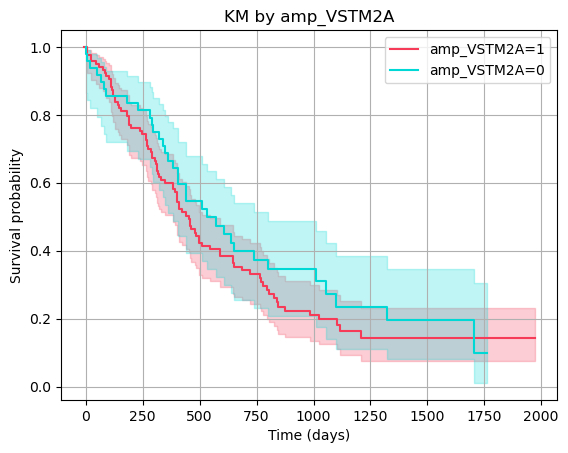

Median survival (1): 453.0
Median survival (0): 534.0


   test_statistic         p  -log2(p)
0        0.950884  0.329494  1.601674


------------------------ Working on amp_VOPP1 ------------------------
N with event (amp_VOPP1=1): 130
N with event (amp_VOPP1=0): 40


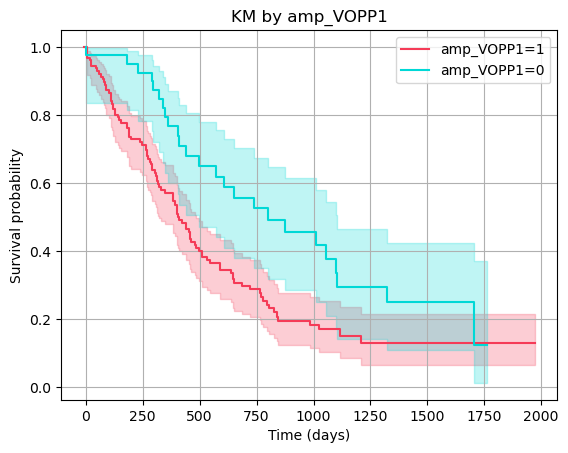

Median survival (1): 411.0
Median survival (0): 799.0


   test_statistic         p  -log2(p)
0        7.683661  0.005572  7.487511


--------------------- Working on amp_AC092647.5 ----------------------
N with event (amp_AC092647.5=1): 125
N with event (amp_AC092647.5=0): 45


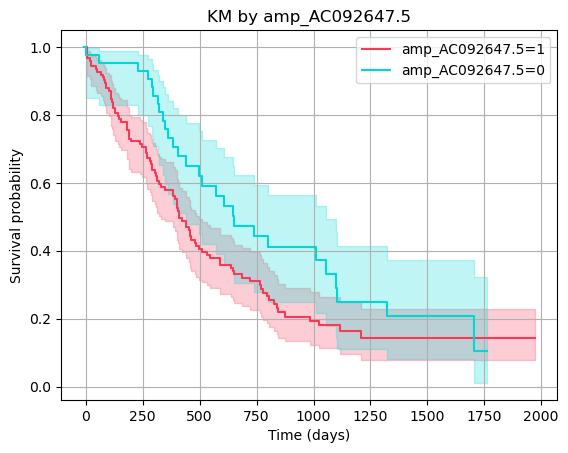

Median survival (1): 411.0
Median survival (0): 651.0


   test_statistic         p  -log2(p)
0        4.254689  0.039142  4.675134


----------------------- Working on amp_MRPS17 ------------------------
N with event (amp_MRPS17=1): 125
N with event (amp_MRPS17=0): 45


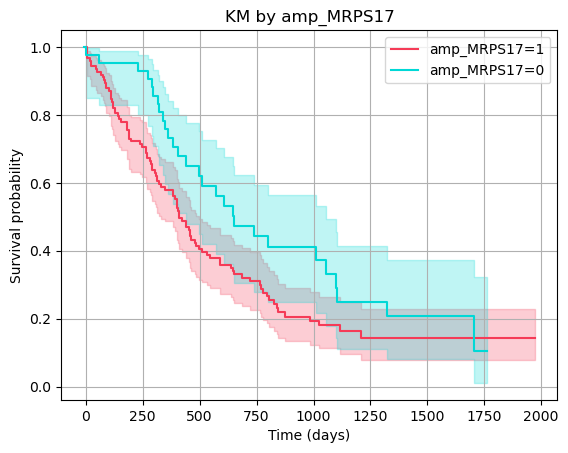

Median survival (1): 411.0
Median survival (0): 651.0


   test_statistic         p  -log2(p)
0        4.254689  0.039142  4.675134


---------------------- Working on amp_NIPSNAP2 -----------------------
N with event (amp_NIPSNAP2=1): 125
N with event (amp_NIPSNAP2=0): 45


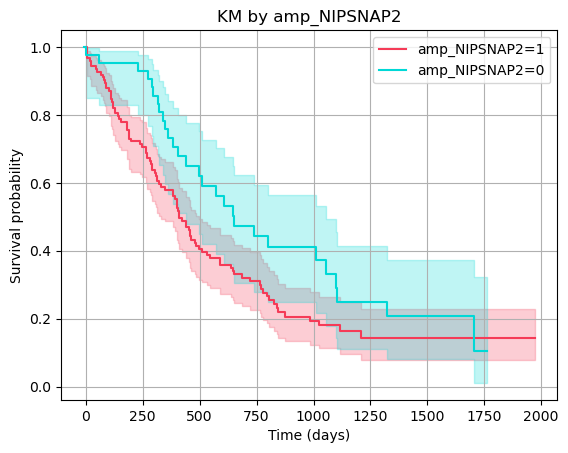

Median survival (1): 411.0
Median survival (0): 651.0


   test_statistic         p  -log2(p)
0        4.254689  0.039142  4.675134


------------------------ Working on amp_PSPH -------------------------
N with event (amp_PSPH=1): 125
N with event (amp_PSPH=0): 45


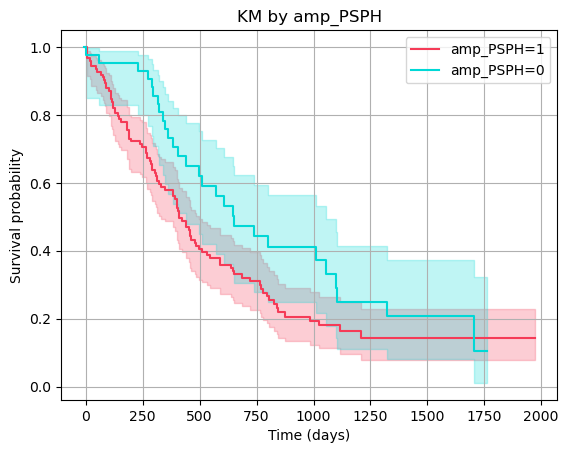

Median survival (1): 411.0
Median survival (0): 651.0


   test_statistic         p  -log2(p)
0        4.254689  0.039142  4.675134


---------------------- Working on amp_SEPTIN14 -----------------------
N with event (amp_SEPTIN14=1): 126
N with event (amp_SEPTIN14=0): 44


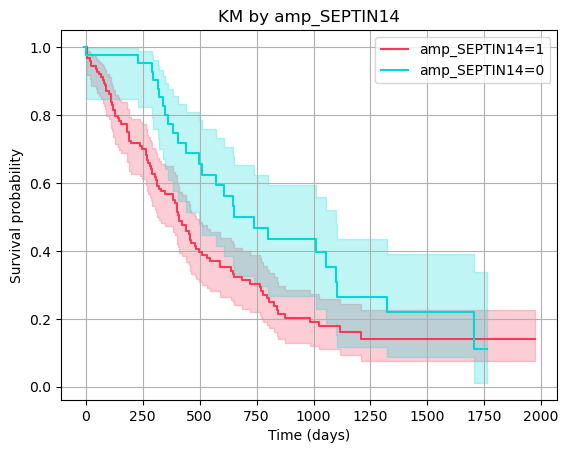

Median survival (1): 409.0
Median survival (0): 651.0


   test_statistic         p  -log2(p)
0        6.105947  0.013473   6.21381


--------------------- Working on amp_AC025165.3 ----------------------
N with event (amp_AC025165.3=1): 17
N with event (amp_AC025165.3=0): 153


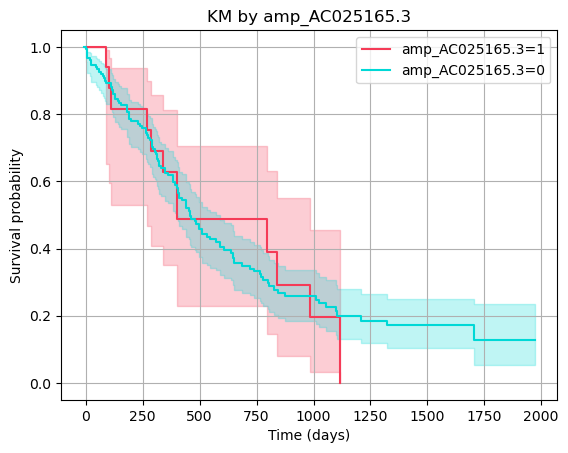

Median survival (1): 402.0
Median survival (0): 457.0


   test_statistic         p  -log2(p)
0        0.010637  0.917857  0.123659


------------------------ Working on amp_AGAP2 ------------------------
N with event (amp_AGAP2=1): 18
N with event (amp_AGAP2=0): 152


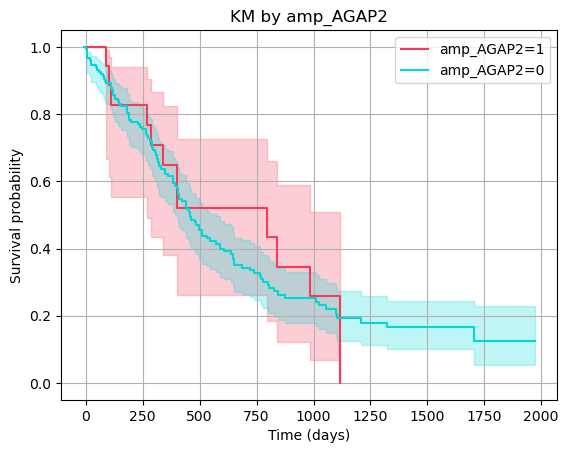

Median survival (1): 797.0
Median survival (0): 457.0


   test_statistic         p  -log2(p)
0         0.11474  0.734811  0.444556


------------------------ Working on amp_CCT6A ------------------------
N with event (amp_CCT6A=1): 124
N with event (amp_CCT6A=0): 46


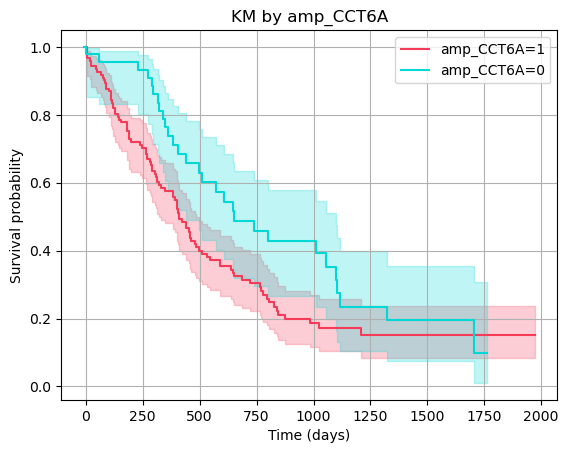

Median survival (1): 411.0
Median survival (0): 651.0


   test_statistic         p  -log2(p)
0        4.714519  0.029909   5.06328


------------------------ Working on amp_CDK4 -------------------------
N with event (amp_CDK4=1): 18
N with event (amp_CDK4=0): 152


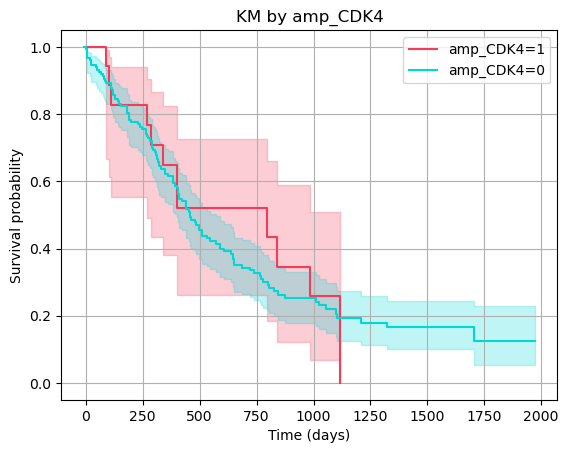

Median survival (1): 797.0
Median survival (0): 457.0


   test_statistic         p  -log2(p)
0         0.11474  0.734811  0.444556


----------------------- Working on amp_CYP27B1 -----------------------
N with event (amp_CYP27B1=1): 18
N with event (amp_CYP27B1=0): 152


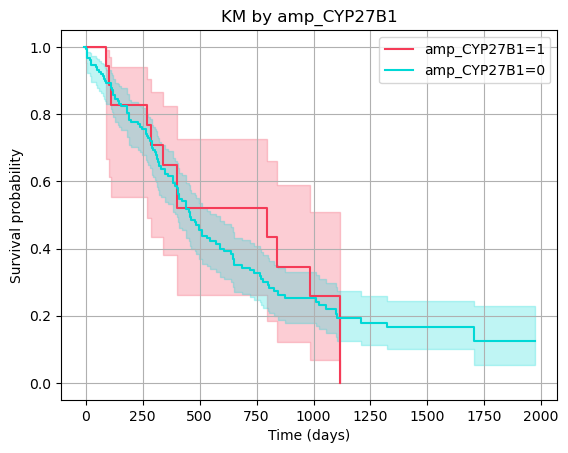

Median survival (1): 797.0
Median survival (0): 457.0


   test_statistic         p  -log2(p)
0         0.11474  0.734811  0.444556


---------------------- Working on amp_EEF1AKMT3 ----------------------
N with event (amp_EEF1AKMT3=1): 17
N with event (amp_EEF1AKMT3=0): 153


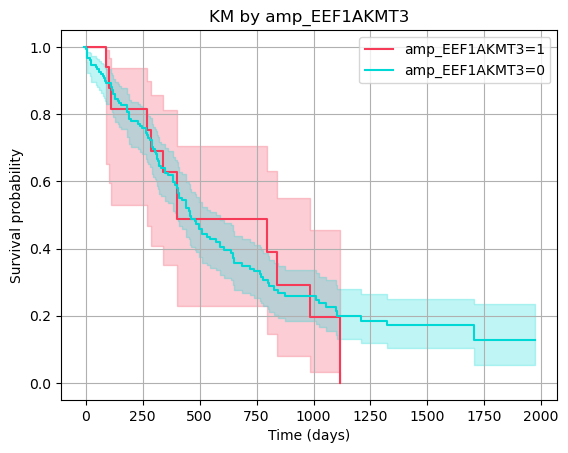

Median survival (1): 402.0
Median survival (0): 457.0


   test_statistic         p  -log2(p)
0        0.010637  0.917857  0.123659


----------------------- Working on amp_MARCHF9 -----------------------
N with event (amp_MARCHF9=1): 18
N with event (amp_MARCHF9=0): 152


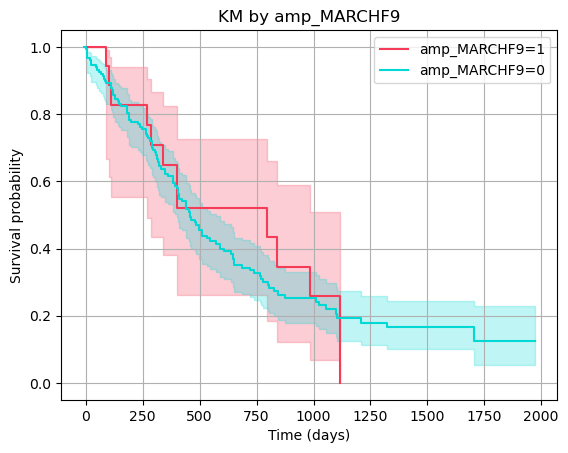

Median survival (1): 797.0
Median survival (0): 457.0


   test_statistic         p  -log2(p)
0         0.11474  0.734811  0.444556


----------------------- Working on amp_METTL1 ------------------------
N with event (amp_METTL1=1): 17
N with event (amp_METTL1=0): 153


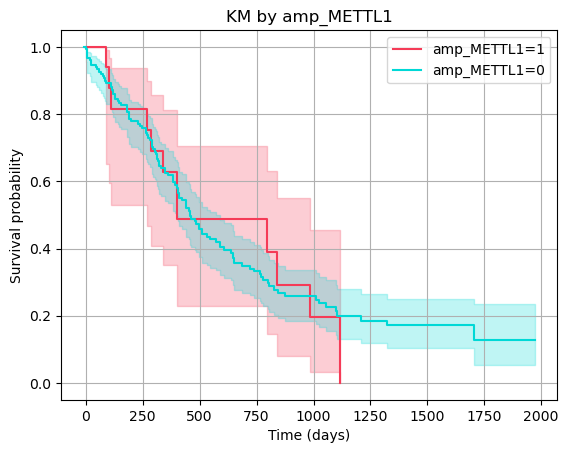

Median survival (1): 402.0
Median survival (0): 457.0


   test_statistic         p  -log2(p)
0        0.010637  0.917857  0.123659


------------------------- Working on amp_OS9 -------------------------
N with event (amp_OS9=1): 18
N with event (amp_OS9=0): 152


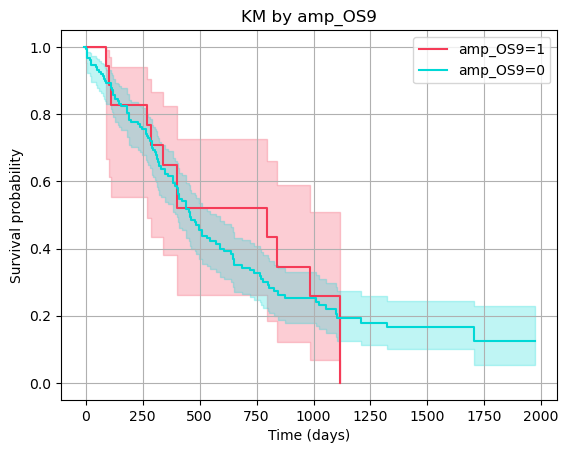

Median survival (1): 797.0
Median survival (0): 457.0


   test_statistic         p  -log2(p)
0         0.11474  0.734811  0.444556


------------------------ Working on amp_SUMF2 ------------------------
N with event (amp_SUMF2=1): 124
N with event (amp_SUMF2=0): 46


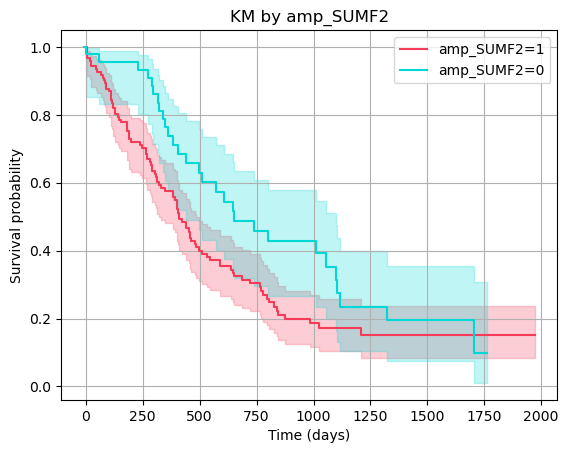

Median survival (1): 411.0
Median survival (0): 651.0


   test_statistic         p  -log2(p)
0        4.714519  0.029909   5.06328




In [13]:
# km_logrank(df,"VOPP1")
genes = gene_df.columns[1:]
pdict =  dict()

print(f"{' Working on CNVs ':=^70}")
for gene in genes:
    print(f"{f' Working on {gene} ':-^70}")
    gene_name = gene.split('_')[1]
    pval  = km_logrank(main_df,gene,pdict)
    pdict[gene_name] = pval

In [14]:
pd.DataFrame(pdict.items(), columns=['gene','pval']).sort_values(by='pval').reset_index(drop=True)

,gene,pval
0,VOPP1,0.005572
1,LANCL2,0.010988
2,SEPTIN14,0.013473
3,CCT6A,0.029909
4,SUMF2,0.029909
5,AC092647.5,0.039142
6,MRPS17,0.039142
7,NIPSNAP2,0.039142
8,PSPH,0.039142
9,EGFR,0.154972
